<a href="https://colab.research.google.com/github/Satwikram/NLP-Implementations/blob/main/Fine%20Tune%20BERT%20with%20Custom%20Loss.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Author: Satwik Ram

### Connecting to Kaggle

In [1]:
from google.colab import files

files.upload()


! mkdir ~/.kaggle


! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


### Downloading the dataset

In [2]:
!kaggle competitions download -c sentiment-analysis-on-movie-reviews

  0% 0.00/1.28M [00:00<?, ?B/s]
100% 1.28M/1.28M [00:00<00:00, 42.6MB/s]
  0% 0.00/494k [00:00<?, ?B/s]
100% 494k/494k [00:00<00:00, 87.4MB/s]
  0% 0.00/583k [00:00<?, ?B/s]
100% 583k/583k [00:00<00:00, 82.6MB/s]


In [3]:
!unzip /content/train.tsv.zip

Archive:  /content/train.tsv.zip
  inflating: train.tsv               


In [4]:
!unzip /content/test.tsv.zip

Archive:  /content/test.tsv.zip
  inflating: test.tsv                


### Importing Dependencies


In [5]:
!pip install transformers

     |████████████████████████████████| 2.9 MB 2.6 MB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 895 kB 34.7 MB/s 
     |████████████████████████████████| 3.3 MB 37.2 MB/s 
     |████████████████████████████████| 596 kB 43.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [6]:
import numpy as np
import pandas as pd

import tensorflow as tf

### Loading Dataset


In [7]:
dataset = pd.read_csv("/content/train.tsv", sep = "\t")

In [8]:
dataset.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


### Dataset labels description

The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   PhraseId    156060 non-null  int64 
 1   SentenceId  156060 non-null  int64 
 2   Phrase      156060 non-null  object
 3   Sentiment   156060 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [10]:
dataset = dataset.drop_duplicates(subset=['SentenceId'], keep='first')

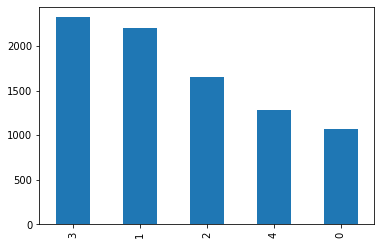

In [11]:
dataset["Sentiment"].value_counts().plot(kind = "bar")

In [12]:
sequence_length = 256
num_samples = len(dataset)

num_samples, sequence_length

(8529, 256)

### Importing BERT Tokenizer

In [13]:
from transformers import BertTokenizer

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
tokens = tokenizer(dataset["Phrase"].tolist(), max_length = sequence_length, 
                   truncation = True, padding = "max_length", add_special_tokens = True,
                   return_tensors = "np")

In [16]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [17]:
tokens["input_ids"]

array([[ 101, 1037, 2186, ...,    0,    0,    0],
       [ 101, 2023, 4251, ...,    0,    0,    0],
       [ 101, 2130, 4599, ...,    0,    0,    0],
       ...,
       [ 101, 1011, 1048, ...,    0,    0,    0],
       [ 101, 1996, 3185, ...,    0,    0,    0],
       [ 101, 1996, 2143, ...,    0,    0,    0]])

In [18]:
tokens["attention_mask"]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

### Saving in numpy format

In [19]:
with open("xids.npy", "wb") as f:
  np.save(f, tokens["input_ids"])

with open("xmasks.npy", "wb") as f:
  np.save(f, tokens["attention_mask"])

### Taking target

In [20]:
arr = dataset["Sentiment"].values

In [21]:
arr.shape, arr.max()+1

((8529,), 5)

In [22]:
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(8529, 5)

In [23]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [24]:
labels[np.arange(num_samples), arr] = 1

### Saving the labels

In [25]:
with open("labels.npy", "wb") as f:
  np.save(f, labels)

### Creating pipeline


In [26]:
with open("xids.npy", "rb") as f:
  Xids = np.load(f, allow_pickle = True)

with open("xmasks.npy", "rb") as f:
  Xmasks = np.load(f, allow_pickle = True)

with open("labels.npy", "rb") as f:
  labels = np.load(f, allow_pickle = True)

In [27]:
Xids

array([[ 101, 1037, 2186, ...,    0,    0,    0],
       [ 101, 2023, 4251, ...,    0,    0,    0],
       [ 101, 2130, 4599, ...,    0,    0,    0],
       ...,
       [ 101, 1011, 1048, ...,    0,    0,    0],
       [ 101, 1996, 3185, ...,    0,    0,    0],
       [ 101, 1996, 2143, ...,    0,    0,    0]])

### Creating the tensorflow dataset

In [28]:
dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmasks, labels))

In [29]:
dataset.take(1)

<TakeDataset shapes: ((256,), (256,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

In [30]:
def map_fun(input_ids, masks, labels):

  return {"input_ids": input_ids,
          "attention_mask": masks}, labels

In [31]:
dataset = dataset.map(map_fun)

In [32]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (256,), attention_mask: (256,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

### Dataset shuffling

In [33]:
batch_size = 8

In [34]:
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder = True)

In [35]:
dataset.take(1)

<TakeDataset shapes: ({input_ids: (8, 256), attention_mask: (8, 256)}, (8, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

### Splitting Data into Train, Test and Val

In [36]:
ds_size = len(dataset)

In [37]:
train_split = 0.8
val_split = 0.1
test_split = 0.1

In [38]:
train_size = int(train_split * ds_size)

In [39]:
val_size = int(val_split * ds_size)

In [40]:
train_ds = dataset.take(train_size)    
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size)

### Saving the data


In [41]:
tf.data.experimental.save(train_ds, "train")
tf.data.experimental.save(val_ds, "val")
tf.data.experimental.save(test_ds, "test")

In [42]:
train_ds.element_spec == val_ds.element_spec == test_ds.element_spec

True

### Loading the dataset

In [43]:
ds = tf.data.experimental.load("train", element_spec = train_ds.element_spec)

In [44]:
ds.take(1)

<TakeDataset shapes: ({input_ids: (8, 256), attention_mask: (8, 256)}, (8, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

### Building the BERT model


In [45]:
from transformers import TFAutoModel

### Fine-Tuning the BERT

In [79]:
def build_model():

  input_ids = tf.keras.layers.Input(shape = (256,), name = "input_ids",
                                  dtype = "int32")

  mask = tf.keras.layers.Input(shape = (256,), name = "attention_mask",
                                  dtype = "int32")
  
  model = TFAutoModel.from_pretrained("bert-base-uncased")

  print(model.summary())
  
  embeddings = model.bert(input_ids, attention_mask = mask)[1]

  x = tf.keras.layers.Dense(1024, activation = "relu")(embeddings)
  
  y = tf.keras.layers.Dense(5, activation = "softmax", name = "outputs")(x)

  model = tf.keras.Model(inputs = [input_ids, mask], outputs = y)

  print(model.summary())

  return model

In [80]:
model = build_model()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  109482240 
Total params: 109,482,240
Trainable params: 109,482,240
Non-trainable params: 0
_________________________________________________________________
None
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          [(None, 256)]        0                                            
__________________________________________________________________________________________________
attention_mask (InputLayer)     [(None, 256)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMai

### Custom Loss Function (Focusing on F1 Score loss)

In [48]:
import tensorflow.keras.backend as K

In [62]:
def f1(y_true, y_pred):

    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)

def f1_loss(y_true, y_pred):
    
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [81]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 5e-5, decay = 1e-6)
loss = f1_loss

In [82]:
model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])

In [83]:
element_spec = ds.element_spec

### Loading Dataset

In [84]:
train_ds = tf.data.experimental.load("train", element_spec = element_spec)
val_ds = tf.data.experimental.load("val", element_spec = element_spec)
test_ds = tf.data.experimental.load("test", element_spec = element_spec)

### Checkpoints and Callbacks

In [85]:
checkpoint = tf.keras.callbacks.ModelCheckpoint("models1/model", monitor = "val_loss", save_best_only = True, 
                                                verbose = 1, mode = "min")

earlystopping = tf.keras.callbacks.EarlyStopping( monitor = "val_loss", verbose = 1, restore_best_weights = True,
                                                 patience = 2, mode = "min")

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor = 0.2,
                              patience = 1, min_lr = 0.001, verbose = 1, mode = "min")

callbacks = [checkpoint, earlystopping, reduce_lr]

### Model Training

In [ ]:
history = model.fit(train_ds, validation_data =  val_ds, epochs = 10)

Epoch 1/10
852/852 [==============================] - 742s 858ms/step - loss: 1.3298 - accuracy: 0.4038 - val_loss: 1.0176 - val_accuracy: 0.5142
Epoch 2/10
852/852 [==============================] - 730s 857ms/step - loss: 1.0346 - accuracy: 0.5398 - val_loss: 0.9514 - val_accuracy: 0.6026
Epoch 3/10
852/852 [==============================] - 728s 855ms/step - loss: 0.8211 - accuracy: 0.6514 - val_loss: 0.8964 - val_accuracy: 0.6557
Epoch 4/10
852/852 [==============================] - 729s 855ms/step - loss: 0.6432 - accuracy: 0.7388 - val_loss: 0.8259 - val_accuracy: 0.7087
Epoch 5/10
375/852 [============>.................] - ETA: 6:30 - loss: 0.5124 - accuracy: 0.7930